# Model building

### pre process

In [170]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from functools import partial
import pandas as pd
import pickle

# Loading embedding model for the textual features
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
def get_sentence_embedding(text):
    embedding = embedding_model.encode(text, convert_to_tensor=False)
    return np.array(embedding)


def string_to_embedding_feature(df, col):
    """
    Convert string column to embedding vector 
    """
    df[col] = df[col].astype(str).fillna(" ") # fill missing values 
    df[f'{col}_embedding'] = df[col].apply(get_sentence_embedding)
    pca = PCA(n_components=50) # Reduce embedding size to 50 
    df_pca = pca.fit_transform(np.stack(df[f'{col}_embedding']))
    df_pca = pd.DataFrame(df_pca, columns=[f'{col}_pca_{i+1}' for i in range(df_pca.shape[1])]).reset_index(drop=True)
    pickle_out = open(f"trained_models/pca_trained_{col}.pickle", "wb")
    pickle.dump(pca, pickle_out)
    pickle_out.close()
    return df_pca


def pre_process(df, used_features):
    """
    Prepare df for modeling- split into X (features) and y (labels)
    """
    df['connections'] = df['connections'].astype(int)
    numeric_features = used_features['numeric']
    X = df[numeric_features].reset_index(drop=True)
    for text_col in used_features['textual']:
        df_pca = string_to_embedding_feature(df, text_col)
        X = pd.concat([X, df_pca], axis=1)
    y = df['is_influencer']
    return X, y


def learn_and_eval(X, y, model_class):
    """
    Model Evaluation: Preform StratifiedKFold CV (because of label unbalancing) and calculate f1 score
    """
    print(model_class)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1 = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_train, y_test = y_train.values.ravel(), y_test.values.ravel(), 
        model = model_class()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fold_f1 = f1_score(y_test, y_pred)
        f1.append(fold_f1)
    
    avg_f1 = sum(f1)/len(f1)
    print(f"Average f1: {avg_f1}")
    return avg_f1

### Testing Several Models

In [158]:
import pandas as pd
# Read the data
df = pd.read_pickle("data/df_for_modeling.pickle")
print("DataFrame Shape: ", df.shape)
df.head(2)

DataFrame Shape:  (760, 21)


,about,connections,is_influencer,certifications,education,experience,followers,languages,position,posts,...,recommendations_count,volunteer_experience,сourses,certifications_count,volunteer_experience_count,сourses_count,education_count,experience_count,posts_count,languages_count
0,NaN,2,0.0,[],[],[{'subtitle': 'Montana State University Billin...,2.0,[],Student Support Specialist at Montana State Un...,[],...,NaN,[],[],0,0,0,0.0,1.0,0,0
1,NaN,113,0.0,"[{'subtitle': 'Achievement', 'title': 'Dragon ...","[{'degree': 'Associate's degree', 'end_year': ...",[{'duration': 'Jun 2016 - Present 7 years 4 mo...,114.0,"[{'subtitle': '-', 'title': 'English'}]",--,[],...,NaN,[],[],1,0,0,3.0,3.0,0,1


In [173]:
used_features = {'numeric': ['followers', 'posts_count', 'experience_count', 'education_count'], 'textual': ['about', 'position', 'recommendations']}
X, y = pre_process(df, used_features=used_features)
lr_model = partial(LogisticRegression, max_iter=10000)
xgb_model = partial(XGBClassifier, n_estimators=200, max_depth=30, eta=0.1, gamma=0.2, reg_lambda=0.5, min_child_weight=2)
rf_model = partial(RandomForestClassifier, max_depth=30)
f1_lr = learn_and_eval(X, y, lr_model)
f1_xgb = learn_and_eval(X, y, xgb_model)
f1_rf = learn_and_eval(X, y, rf_model)

functools.partial(<class 'sklearn.linear_model._logistic.LogisticRegression'>, max_iter=10000)
Average f1: 0.7784265010351967
functools.partial(<class 'xgboost.sklearn.XGBClassifier'>, n_estimators=200, max_depth=30, eta=0.1, gamma=0.2, reg_lambda=0.5, min_child_weight=2)
Average f1: 0.8451511387163562
functools.partial(<class 'sklearn.ensemble._forest.RandomForestClassifier'>, max_depth=30)
Average f1: 0.6366471734892787


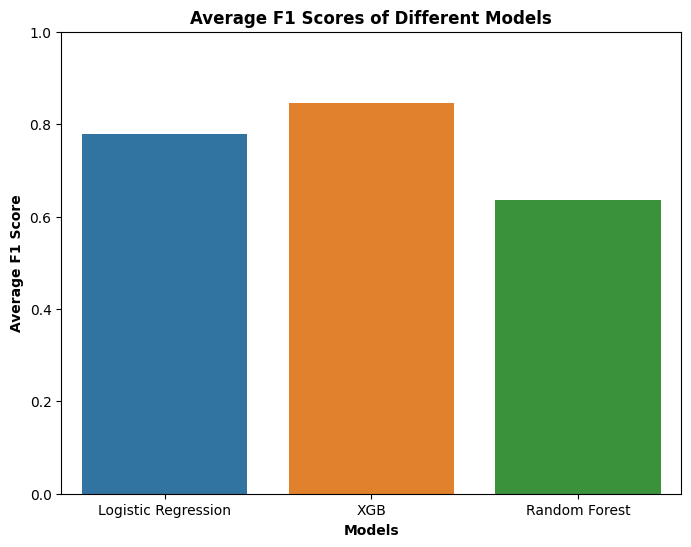

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt

# model comparison visualization 
models = ['Logistic Regression', 'XGB', 'Random Forest']
average_f1_scores = [f1_lr, f1_xgb, f1_rf]
plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=average_f1_scores)
plt.title('Average F1 Scores of Different Models', weight="bold")
plt.xlabel('Models', weight="bold")
plt.ylabel('Average F1 Score', weight="bold")

plt.ylim(0, 1) 
plt.show()


### Training the model on the entire data (for the courses recommendations part)

In [176]:
model = XGBClassifier(n_estimators=200, max_depth=30, eta=0.1, gamma=0.2, reg_lambda=0.5, min_child_weight=2) 
model.fit(X, y)
model_pickle_out = open(f"trained_models/trained_model.pickle", "wb")
pickle.dump(model, model_pickle_out)
model_pickle_out.close()